In [1]:
import numpy as np
from os import path
import matplotlib.pyplot as plt

In [2]:
### Load data

# imresps.npy is of shape (1573, 2, 15363), where 1573 is number of images, 2 repeats each, and 15363 neurons recorded
# stimids.npy has the image id (matching the image dataset ~selection1866~) for each stimulus number, 
# so of you want to see what image was presented on imresps[502] you would check stim_ids[502]

PATH_TO_DATA = '../../data/neural'

imresps = np.load(path.join(PATH_TO_DATA, 'imresps.npy'))
stimids = np.load(path.join(PATH_TO_DATA, 'stimids.npy'))

print(imresps.shape) # (1573, 2, 15363)
print(stimids.shape) # (1573,)

(1573, 2, 15363)
(1573,)


In [3]:
def compute_signal_related_variance(resp_a, resp_b, mean_center=True):
    """
    compute the fraction of signal-related variance for each neuron,
    as per Stringer et al Nature 2019. Cross-validated by splitting
    responses into two halves. Note, this only is "correct" if resp_a
    and resp_b are *not* averages of many trials.

    Args:
        resp_a (ndarray): n_stimuli, n_cells
        resp_b (ndarray): n_stimuli, n_cells

    Returns:
        fraction_of_stimulus_variance: 0-1, 0 is non-stimulus-caring, 1 is only-stimulus-caring neurons
        stim_to_noise_ratio: ratio of the stim-related variance to all other variance
    """
    if len(resp_a.shape) > 2:
        # if the stimulus is multi-dimensional, flatten across all stimuli
        resp_a = resp_a.reshape(-1, resp_a.shape[-1])
        resp_b = resp_b.reshape(-1, resp_b.shape[-1])
    ns, nc = resp_a.shape
    if mean_center:
        # mean-center the activity of each cell
        resp_a = resp_a - resp_a.mean(axis=0)
        resp_b = resp_b - resp_b.mean(axis=0)
    
    # compute the cross-trial stimulus covariance of each cell
    # dot-product each cell's (n_stim, ) vector from one half
    # with its own (n_stim, ) vector on the other half

    covariance = (resp_a * resp_b).sum(axis=0) / ns

    # compute the variance of each cell across both halves
    resp_a_variance = (resp_a**2).sum(axis=0) / ns
    resp_b_variance = (resp_b**2).sum(axis=0) / ns
    total_variance = (resp_a_variance + resp_b_variance) / 2

    if np.any(total_variance < 1e-12):
        print(f"Warning: Near-zero total variance for neurons: {np.where(total_variance < 1e-12)[0]}")

    # compute the fraction of the total variance that is
    # captured in the covariance
    fraction_of_stimulus_variance = covariance / total_variance

    # if you want, you can compute SNR as well:
    stim_to_noise_ratio = fraction_of_stimulus_variance / (
        1 - fraction_of_stimulus_variance
    )

    return fraction_of_stimulus_variance, stim_to_noise_ratio

[-0.01630815  0.02766815  0.00207127 ...  0.05944982 -0.00494682
 -0.02061212]
[ 0.0187036  -0.03139828  0.02746979 ...  0.01586281  0.03691415
 -0.02663723]


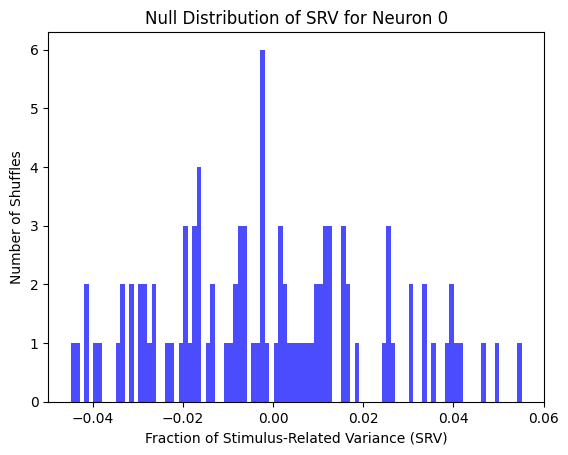

In [4]:
### Compute the null distribution of SRV values for all neurons

# imresps shape = (1573, 2, 15363)
# responses in imresps shape = (2, 15363)
num_stimuli = imresps.shape[0] # 1573
num_repeats = imresps.shape[1] # 2
num_neurons = imresps.shape[2] # 15363
n_shuffles = 100

null_srv_all_neurons = [] # shape (n_shuffles, num_neurons)

for _ in range(n_shuffles):
    # Shuffle stimulus indices *twice* to create two independent splits!
    shuffled_indices_A = np.random.permutation(num_stimuli)
    shuffled_indices_B = np.random.permutation(num_stimuli)

    # Now for the splits, we can just use fixed repeat indices, 
    # because for each split, at index N the responses correspond to different stimuli
    # e.g. split_A = [ stim_100_repeat_1, stim_2_repeat_1, stim_19_repeat_1, ... ]
    # e.g. split_B = [ stim_543_repeat_2, stim_345_repeat_2, stim_3_repeat_2, ... ]
    split_A = imresps[shuffled_indices_A, 0, :]
    split_B = imresps[shuffled_indices_B, 1, :]

    # Compute SRV for the shuffled data
    fraction_of_stimulus_variance, _ = compute_signal_related_variance(split_A, split_B)
    null_srv_all_neurons.append(fraction_of_stimulus_variance)

null_srv_all_neurons = np.array(null_srv_all_neurons)
null_srv_all_neurons.shape # (100, 15363)

print(null_srv_all_neurons[0])
print(null_srv_all_neurons[33])

# e.g. if neuron_index = 0, it will plot the SRV value for neuron 0 across all shuffles
neuron_index = 0
plt.hist([srv[neuron_index] for srv in null_srv_all_neurons], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

[-0.02848782 -0.00797794 -0.03593934 ...  0.20568666  0.03094687
  0.02276523]
[-0.02769875 -0.00791479 -0.03469251 ...  0.25894901  0.03193517
  0.02329556]
Real SRV shape: (15363,)


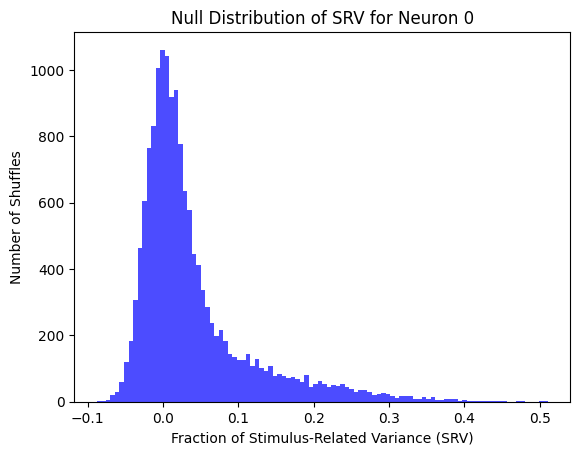

In [5]:
### Compute the real SRV for each neuron

# split_A_real = imresps[:, 0, :] # First repeat for each stimulus
# split_B_real = imresps[:, 1, :] # Second repeat for each stimulus

split_A, split_B = [], []
for responses in imresps: # responses shape: (2, n_neurons)
    indices = np.random.permutation(2) # Randomly shuffle [0, 1]
    split_A.append(responses[indices[0]]) # Assign one repeat to split_A
    split_B.append(responses[indices[1]]) # Assign the other to split_B

split_A = np.array(split_A)  # Shape: (n_stimuli, n_neurons)
split_B = np.array(split_B)  # Shape: (n_stimuli, n_neurons)

# Compute SRV for real data
real_srv_all_neurons, stim_to_noise_ratio = compute_signal_related_variance(split_A, split_B)

print(real_srv_all_neurons)
print(stim_to_noise_ratio)

print("Real SRV shape:", real_srv_all_neurons.shape) # Should be (15363,)

plt.hist(real_srv_all_neurons, bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

[0.04939693 0.05505107 0.06431829 ... 0.06330969 0.07074307 0.05586326]
Number of reliable neurons: 3687
Indices of reliable neurons: [   14    70    71 ... 15356 15358 15360]


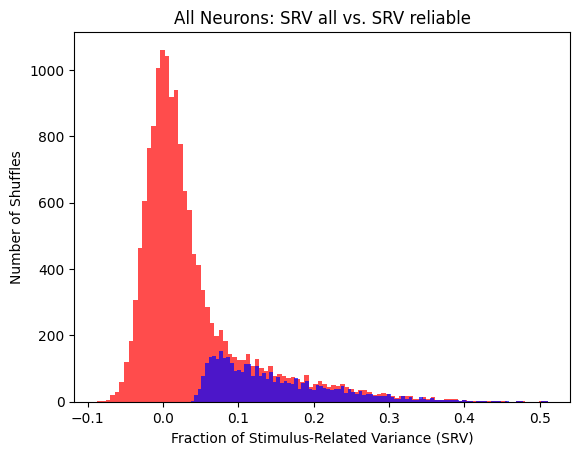

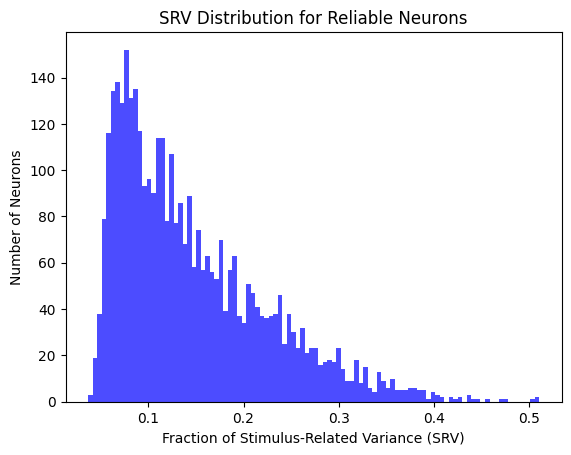

In [6]:
### Filter neurons whose real SRV is in the top 90th percentile of its null distribution

# This gives the 90th-percentile SRV value of the null distribution for each neuron
# In other words the threshold for each neuron to be considered reliable
# e.g. if neuron 0 has a null distribution of SRVs across 10 shuffles 
# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], the threshold would be 0.9
top_99th_percentile_null = np.percentile(null_srv_all_neurons, 99, axis=0)
print(top_99th_percentile_null) # [0.03651716 0.03126347 0.03325775 ... 0.02738261 0.03546677 0.0333109 ]

# Get indices of reliable neurons
reliable_neuron_indices = np.where(real_srv_all_neurons >= top_99th_percentile_null)[0]

# Print results
print(f"Number of reliable neurons: {len(reliable_neuron_indices)}") # 5654
print(f"Indices of reliable neurons: {reliable_neuron_indices}") # [   14    29    48 ... 15357 15358 15360]

plt.hist(real_srv_all_neurons, bins=100, color='red', alpha=0.7)
plt.hist(real_srv_all_neurons[reliable_neuron_indices], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title("All Neurons: SRV all vs. SRV reliable")
plt.show()

plt.hist(real_srv_all_neurons[reliable_neuron_indices], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Neurons")
plt.title("SRV Distribution for Reliable Neurons")
plt.show()

[   1    2    3 ... 1858 1859 1860]
[1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]
List: ['img1.mat', 'img10.mat', 'img100.mat', 'img1000.mat', 'img1001.mat', 'img1002.mat', 'img1003.mat', 'img1004.mat', 'img1005.mat', 'img1006.mat', 'img1007.mat', 'img1008.mat', 'img1009.mat', 'img101.mat', 'img1010.mat', 'img1011.mat', 'img1012.mat', 'img1013.mat', 'img1014.mat', 'img1015.mat', 'img1016.mat', 'img1017.mat', 'img1018.mat', 'img1019.mat', 'img102.mat', 'img1020.mat', 'img1021.mat', 'img1022.mat', 'img1023.mat', 'img1024.mat', 'img1025.mat', 'img1026.mat', 'img1027.mat', 'img1028.mat', 'img1029.mat', 'img103.mat', 'img1030.mat', 'img1031.mat', 'img1032.mat', 'img1033.mat', 'img1034.mat', 'img1035.mat', 'img1036.mat', 'img1037.mat', 'img1038.mat', 'img1039.mat', 'img104.mat', 'img1040.mat', 'img1041.mat', 'img1042.mat', 'img1043.mat', 'img1044.mat', 'img1045.mat', 'img1046.mat', 'img1047.mat', 'img1048.mat', 'img1049.mat', 'img105.mat', 'img1050.mat', 'img1051.mat', 'i

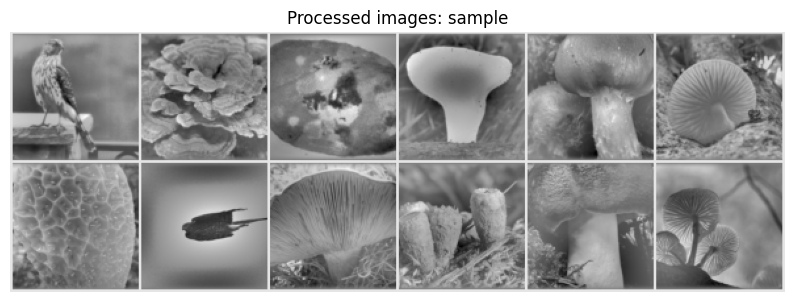

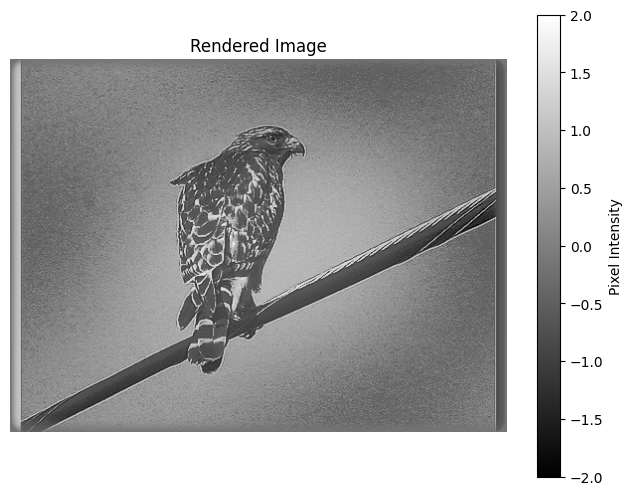

In [7]:
### Load and preprocess images

import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Normalize, Compose, Resize, CenterCrop
import torch
from torch.utils.data import TensorDataset
from torchvision import utils as torch_utils
 
PATH_TO_DATA = '../../data/selection1866'

file_list = sorted(f for f in os.listdir(PATH_TO_DATA) if f.endswith('.mat'))
stim_ids = stimids.astype(int)

print(stim_ids)
print(stimids)

transform = Compose([
    Resize(96), # Resize shortest edge to 96 (cut off the rightmost part of the image)
    CenterCrop((96, 96)), # Crop to (96, 96)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # !! Normalize expects input is already in the range [0, 1]
])

img_tensors, labels = [], []

print('List:', file_list)

# we have 1866 images here, but the neural response data only uses 1573 of them
# because some ~300 images didn't have two repeats, so were disposed
# therefore we filter the full set here so that we only use the relevant 1573
for stim_id in stim_ids:
    filename = 'img' + str(stim_id) + '.mat'
    data = loadmat(os.path.join(PATH_TO_DATA, filename))

    img = data['img'][:, :500] # Take leftmost part of the image
    rgb_img = np.stack([img] * 3, axis=-1) # Convert grayscale to RGB for SimCLR
    tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
    
    # Min-max scale the tensor to [0, 1]
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    tensor = (tensor - tensor_min) / (tensor_max - tensor_min)

    # Clamp to [0, 1] to ensure no outliers due to numerical precision
    tensor = torch.clamp(tensor, 0.0, 1.0)

    transformed_tensor = transform(tensor) # Normalize and resize for SimCLR
    img_tensors.append(transformed_tensor)
    labels.append(stim_id)

image_dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

images, labels = image_dataset.tensors
print("Processed image labels (stim id):", labels[:30])
print("Stim IDs from neural data:", stim_ids[:30])
print("Processed dataset shape:", images.shape) # (N, C, 96, 96)
print(f"Min pixel value (processed): {torch.min(images)}")
print(f"Max pixel value (processed): {torch.max(images)}")

# Show a sample of processed images
img_grid = torch_utils.make_grid(images[:12], nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.title('Processed images: sample')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

filename = 'img20.mat'
data = loadmat(os.path.join(PATH_TO_DATA, filename))
img = data['img'][:, :500]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')  # Adjust cmap as needed ('viridis', 'jet', etc.)
plt.colorbar(label="Pixel Intensity")
plt.title("Rendered Image")
plt.axis("off")  # Hide axis for better visualization
plt.show()

In [8]:
### Run images through a pretrained SimCLR model and extract features

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from tqdm.notebook import tqdm
from typing import Dict
from torch.utils.data import Dataset
import urllib.request
from urllib.error import HTTPError
from collections import defaultdict

class SimCLR(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Base ResNet18 backbone (pretrained=False, because we load custom weights later, from the SimCLR checkpoint file)
        self.convnet = torchvision.models.resnet18(pretrained=False)
        
        # This is the projection head, only needed during training. For downstream tasks it is disposed of
        # and the final linear layer output is used (Chen et al., 2020) 
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.intermediate_layers_to_capture =[]
        self.intermediate_layer_features = {}
        self.num_workers = os.cpu_count()
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    def load_pretrained(self):
        """
        Load pretrained SimCLR weights
        """
        base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
        models_dir = "../../models"
        pretrained_simclr_filename = "SimCLR.ckpt"
        pretrained_simclr_path = os.path.join(models_dir, pretrained_simclr_filename)
        os.makedirs(models_dir, exist_ok=True)

        # Check whether the pretrained model file already exists locally. If not, try downloading it
        file_url = base_url + pretrained_simclr_filename
        if not os.path.isfile(pretrained_simclr_path):
            print(f"Downloading pretrained SimCLR model {file_url}...")
            try:
                urllib.request.urlretrieve(file_url, pretrained_simclr_path)
            except HTTPError as e:
                print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

        print(f"Already downloaded pretrained model: {file_url}")

        # Load pretrained model
        checkpoint = torch.load(pretrained_simclr_path, map_location=self.device)
        self.load_state_dict(checkpoint['state_dict'])
        self.to(self.device)
        self.eval()
    
    def set_intermediate_layers_to_capture(self, layers):
        """
        Register hooks to capture features from intermediate layers
        """
        # Just check the layers specified are actually in the convnet
        top_level_block_layers = [name for name, _ in self.convnet.named_children()]
        if not all(layer in top_level_block_layers for layer in layers):
            print('You have specified convnet layers that are not top-level blocks - make sure your layer names are valid')
        
        self.intermediate_layers_to_capture = layers
        intermediate_layer_features = {}

        def get_hook(layer_name):
            def hook(module, input, output):
                intermediate_layer_features[layer_name] = output.detach()
            return hook

        for layer_name in layers:
            layer = dict([*self.convnet.named_modules()])[layer_name]
            layer.register_forward_hook(get_hook(layer_name))

        self.intermediate_layer_features = intermediate_layer_features

    @torch.no_grad()
    def extract_features(self, dataset: Dataset) -> Dict[str, torch.Tensor]:
        """
        Run the pretrained SimCLR model on the image data, and capture features from final layer and intermediate layers.

        Args:
            dataset (Dataset): A PyTorch Dataset containing input images and labels. The image data should have shape (N, C, H, W)

        Returns:
            Dict[str, torch.Tensor]: A dictionary containing:
                - Intermediate layer features as tensors.
                - Final layer features under 'final_layer'.
                - Labels under 'labels'.
            Features from a given layer has shape (N, F) where N is num images, F is number of features - flattened version of (C, H, W).
        """
        self.convnet.fc = nn.Identity()  # Removing projection head g(.)
        self.eval()
        self.to(self.device)
        
        # Encode all images
        data_loader = DataLoader(dataset, batch_size=64, num_workers=self.num_workers, shuffle=False, drop_last=False)
        feats, labels, intermediate_features = [], [], {layer: [] for layer in self.intermediate_layers_to_capture}

        for batch_idx, (batch_imgs, batch_labels) in enumerate(tqdm(data_loader)):
            batch_imgs = batch_imgs.to(self.device)
            batch_feats = self.convnet(batch_imgs)
            
            feats.append(batch_feats.detach().cpu())
            labels.append(batch_labels)

            # Collect intermediate layer outputs
            for layer in self.intermediate_layers_to_capture:
                # Final linear layer outputs a 2d tensor; but intermediate layers don't, so we flatten them (ready for PCA etc.)
                layer_output_flattened = self.intermediate_layer_features[layer].view(self.intermediate_layer_features[layer].size(0), -1) 
                intermediate_features[layer].append(layer_output_flattened.cpu())
        
        # Concatenate results for each layer
        feats = torch.cat(feats, dim=0)
        labels = torch.cat(labels, dim=0)
        intermediate_features = {layer: torch.cat(intermediate_features[layer], dim=0) for layer in self.intermediate_layers_to_capture}

        # Debugging log after concatenation
        print("✅ Feature extraction complete. Final feature shapes:")
        print(f"Final layer: {feats.shape}")
        for layer, feature in intermediate_features.items():
            print(f"{layer}: {feature.shape}")  # Check final stored shape

        return {**intermediate_features, 'final_layer': feats, 'labels': labels}

intermediate_layers = ['layer1', 'layer2', 'layer3', 'layer4']

sim_clr = SimCLR()
sim_clr.load_pretrained()
sim_clr.set_intermediate_layers_to_capture(intermediate_layers)
feats = sim_clr.extract_features(image_dataset)

for layer in ["layer1", "layer2", "layer3", "layer4"]:
    if layer in feats:
        variance = np.var(feats[layer].numpy())
        print(f"{layer} variance: {variance:.6f}")

# Our original images are grayscale, but SimCLR expects 3-channel RGB input.
# To meet this requirement, we duplicated the grayscale values across all three RGB channels.
# However, for PCA, we only need a single channel, so we extract just the first channel (Red).
flattened_images = images[:, 0, :, :].view(images.shape[0], -1) # shape: [1573, 50176] (1573 images, 224x224 pixels)

layer1_feats = feats['layer1'] # Shape: torch.Size([1573, 200704]) (n_images, n_features)
layer2_feats = feats['layer2']
layer3_feats = feats['layer3']
layer4_feats = feats['layer4']
final_layer_feats = feats['final_layer'] # Shape: torch.Size([1573, 512])

print('flattened_images shape', flattened_images.shape)
print('layer1 shape', layer1_feats.shape)
print('final layer shape', final_layer_feats.shape)

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/_c/21m3vmjd7c1_75f4nxmg1k480000gn/T/ipykernel_30391/3425516118.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SE

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


  0%|          | 0/25 [00:00<?, ?it/s]

✅ Feature extraction complete. Final feature shapes:
Final layer: torch.Size([1573, 512])
layer1: torch.Size([1573, 36864])
layer2: torch.Size([1573, 18432])
layer3: torch.Size([1573, 9216])
layer4: torch.Size([1573, 4608])
layer1 variance: 1.844273
layer2 variance: 1.347976
layer3 variance: 1.150262
layer4 variance: 0.852678
flattened_images shape torch.Size([1573, 9216])
layer1 shape torch.Size([1573, 36864])
final layer shape torch.Size([1573, 512])


In [9]:
### 1. Predict PC of neural data (separate model predicts each PC), e.g. predict PC1 neural data from features of layer2
### 2. Feature visualisation of most important features for PC, for layer, each neuron.

from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

images_representations = {
    'raw_pixels': flattened_images,
    'layer1': layer1_feats,
    'layer2': layer2_feats,
    'layer3': layer3_feats,
    'layer4': layer4_feats,
    'fc': final_layer_feats,
}

# ===================================
# Filter only the top Y neurons (SRV)
# ===================================
num_neurons = 500
reliable_srv_scores = real_srv_all_neurons[reliable_neuron_indices]
sorted_indices = np.argsort(reliable_srv_scores)[::-1]
most_reliable_neurons = reliable_neuron_indices[sorted_indices[:num_neurons]]
highest_srv_scores = real_srv_all_neurons[most_reliable_neurons]
neural_responses = imresps[:, :, most_reliable_neurons]
neural_responses_mean = neural_responses.mean(axis=1)

assert most_reliable_neurons.shape[0] == num_neurons, "Mismatch in neuron selection!"
print("Dimensionality of neural responses:", neural_responses_mean.shape)
print("Top 500 reliable neuron indices:", most_reliable_neurons[:10])
print("Corresponding SRV scores:", highest_srv_scores[:10])
print("Top 500 neural responses shape:", neural_responses.shape) # (1573, 2, 500)
print("Averaged top 500 neural responses shape:", neural_responses_mean.shape) # (1573, 500)

# ===================================
# Get PCs of neural data
# ===================================
pca = PCA(10)
neural_data_pcs = pca.fit_transform(neural_responses_mean)
pc1_neural_data = neural_data_pcs[:, 0]
print(pc1_neural_data.shape)

# ===================================
# Regression from image representation to first PC of neural data 
# ===================================
for k in images_representations:
    X_train, X_test, y_train, y_test = train_test_split(images_representations[k], pc1_neural_data, test_size=0.2, random_state=42)

    ridge = Ridge(alpha=1000)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R^2 Score for {k}: {r2:.4f}")

# R^2 Score for raw_pixels: 0.0029
# R^2 Score for layer1_features: 0.4033
# R^2 Score for layer2_features: 0.4820
# R^2 Score for layer3_features: 0.4715
# R^2 Score for layer4_features: 0.3455
# R^2 Score for final_layer_features: 0.0675

Dimensionality of neural responses: (1573, 500)
Top 500 reliable neuron indices: [13560  6355  9560  7456  9531  9363  8882  7057 11562  8854]
Corresponding SRV scores: [0.51056762 0.50976421 0.5038497  0.47613729 0.46935226 0.45589303
 0.44615245 0.44024038 0.43752029 0.43668333]
Top 500 neural responses shape: (1573, 2, 500)
Averaged top 500 neural responses shape: (1573, 500)
(1573,)
R^2 Score for raw_pixels: -0.0490
R^2 Score for layer1: 0.2469
R^2 Score for layer2: 0.3341
R^2 Score for layer3: 0.4204
R^2 Score for layer4: 0.4329
R^2 Score for fc: 0.4550


In [ ]:
### Summary of results for each layer

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

pc_index = 0 # Index of the principal component to predict

results = {}
for k in images_representations:
    # ================================
    # Step 1: Split data into training and test sets
    # ================================
    X_train, X_test, y_train_full, y_test_full = train_test_split(images_representations[k], neural_responses_mean, test_size=0.2, random_state=42)

    # ================================
    # Step 2: Fit PCA only on the training set
    # ================================
    pca = PCA(n_components=10)
    y_train_pcs = pca.fit_transform(y_train_full)  # Fit PCA on training neural data
    y_test_pcs = pca.transform(y_test_full)  # Transform test neural data

    # Extract PC as target variable
    y_train = y_train_pcs[:, pc_index] 
    y_test = y_test_pcs[:, pc_index]

    # ================================
    # Step 3: Perform Cross-Validation for Ridge Regression
    # ================================
    alphas = np.array([0.1, 1, 10, 100, 1000, 100000, 1000000])
    best_alpha = None
    best_score = -np.inf

    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        scores = cross_val_score(ridge, X_train, y_train, cv=kf, scoring="r2")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha

    print(f"Best alpha from CV: {best_alpha:.4f}, Mean CV R²: {best_score:.4f}")

    # ================================
    # Step 4: Train Ridge Regression with Best Alpha
    # ================================
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train, y_train)

    # ================================
    # Step 5: Evaluate Model on Test Set
    # ================================
    y_pred = ridge.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Test R² Score: {r2:.4f}")
    results.update({k: {"best_alpha": best_alpha, "mean_cv_r2": best_score, "test_r2": r2, "ridge": ridge}})

    # ================================
    # Step 6: Plot Predictions vs True PC1 Values
    # ================================
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel(f"True PC{pc_index+1} of Neural Data")
    plt.ylabel(f"Predicted PC{pc_index+1}")
    plt.title(f"Ridge Regression: {k} → PC{pc_index+1} of Neural Data")
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Ideal Fit")
    plt.legend()
    plt.show()

print(results)

In [ ]:
### Plot summary of results across all 

layers = list(results.keys())
mean_cv_r2 = [results[layer]['mean_cv_r2'] for layer in layers]
test_r2 = [results[layer]['test_r2'] for layer in layers]
best_alphas = [results[layer]['best_alpha'] for layer in layers]

plt.figure(figsize=(10, 5))
bar_width = 0.4
x = np.arange(len(layers))
bars1 = plt.bar(x - bar_width/2, mean_cv_r2, bar_width, label="Mean CV R²")
bars2 = plt.bar(x + bar_width/2, test_r2, bar_width, label="Test R² Score")

for i in range(len(layers)):
    plt.text(x[i] - bar_width/2, mean_cv_r2[i] + 0.02, f"α={int(best_alphas[i])}", 
             ha="center", fontsize=10, fontweight="bold")

plt.xlabel("Feature Representation Layer")
plt.ylabel("R² Score")
plt.title(f"Ridge Regression to PC{pc_index+1} of Neural Data (average response of each of the 500 most stimulus-responsive neurons)")
plt.xticks(ticks=x, labels=layers, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# Data preparation
labels = ["Raw Pixels", "SimCLR Layer 1", "SimCLR Layer 2", "SimCLR Layer 3", "SimCLR Layer 4", "SimCLR Final Layer"]
layers = list(results.keys())
test_r2 = [results[layer]['test_r2'] for layer in layers]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(labels, test_r2, marker='o', linestyle='--', color='b')

# Labels and title
# plt.xlabel("Feature Representation Layer")
plt.ylabel("Test R²")
# plt.title("Test R² Scores Across Feature Representation Layers")
plt.xticks(rotation=20)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Show plot
plt.show()

In [ ]:
### Ridge regression feature coefficients

import numpy as np
import matplotlib.pyplot as plt

layers_feats_top_features = {
    'raw_pixels': { 'feats': flattened_images, 'top_features': [], 'coefficients': [], 'coefficients_norm': [], "correlations_pc1": None },
    'layer1': { 'feats': layer1_feats, 'top_features': [], 'coefficients': [], 'coefficients_norm': [], "correlations_pc1": None },
    'layer2': { 'feats': layer2_feats, 'top_features': [], 'coefficients': [], 'coefficients_norm': [], "correlations_pc1": None },
    'layer3': { 'feats': layer3_feats, 'top_features': [], 'coefficients': [], 'coefficients_norm': [], "correlations_pc1": None },
    'layer4': { 'feats': layer4_feats, 'top_features': [], 'coefficients': [], 'coefficients_norm': [], "correlations_pc1": None },
    'fc': { 'feats': final_layer_feats, 'top_features': [], 'coefficients': [], 'coefficients_norm': [], "correlations_pc1": None },
}

for layer in images_representations:
    ridge = results[layer]['ridge']
    # num_feats_in_layer = len(layers_feats_top_features[layer]["feats"][0])
    num_feats_in_layer = layers_feats_top_features[layer]["feats"].shape[1]
    print(layers_feats_top_features[layer]["feats"].shape)
    print(num_feats_in_layer)

    # sort features in desc order of importance
    feature_importance = np.abs(ridge.coef_)
    sorted_indices = np.argsort(feature_importance)[::-1]
    top_features = sorted_indices[:20] # Select top 20 important features
    top_features_coeff_scores = feature_importance[top_features]

    layers_feats_top_features[layer]['top_features'] = top_features
    layers_feats_top_features[layer]['coefficients'] = top_features_coeff_scores

    top_features_coeff_norm_scores = [x / num_feats_in_layer for x in top_features_coeff_scores]
    layers_feats_top_features[layer]['coefficients_norm'] = top_features_coeff_norm_scores

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(top_features)), feature_importance[top_features])
    plt.xticks(range(len(top_features)), top_features, rotation=90)
    plt.xlabel("Feature Index")
    plt.ylabel("Absolute Coefficient Magnitude")
    plt.title(f"[{layer}]: Feature Importance for Predicting PC{pc_index+1} ({layer})")
    plt.show()

print(layers_feats_top_features)

In [ ]:
### Get filters most correlated with PC1 of neural data

import numpy as np
from scipy.stats import pearsonr

# Store filter correlation results
filter_correlations = {}

for k in layers_feats_top_features:
    if k == 'raw_pixels':  # Skip raw pixels if needed
        continue

    print(f"Computing correlations for {k}...")

    # Get all features (filter activations) for this layer
    layer_features = layers_feats_top_features[k]["feats"]  # Shape: (N, num_filters)

    # Compute correlations for ALL filters in this layer
    correlations = np.array([
        pearsonr(layer_features[:, f], pc1_neural_data)[0] for f in range(layer_features.shape[1])
    ])

    # Find the top 10 most correlated features
    top_corr_indices = np.argsort(np.abs(correlations))[::-1][:10]
    
    # Store results
    filter_correlations[k] = {
        'correlations': correlations,  # All correlation values
        'top_indices': top_corr_indices,  # Top 10 filter indices
        'top_corr_values': correlations[top_corr_indices]  # Top 10 correlation values
    }

    layers_feats_top_features[k]["correlations_pc1"] = filter_correlations[k]

    print(f"Top correlated features in {k}: {list(zip(top_corr_indices, correlations[top_corr_indices]))}")

In [ ]:
### feature visualization: generate synthetic images optimized to maximally activate a given feature in a given layer
### order filters by coefficient (feature importance)

# TODO Check size of layer output - is it correct num filters?
# The size of layer output is (1, num_filters, H, W) - dims after pooling etc.
# synthetic images presented were for filter maximally correalted with PC1 - take the max

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def compute_correlation_with_pc1(filter_index, layer_activations, pc1_scores):
    """
    Computes Pearson correlation between a filter's activation across images and PC1 scores.
    
    Args:
        filter_index: Index of the filter in the layer.
        layer_activations: Activation values for all images [N, num_filters].
        pc1_scores: PC1 values for each image [N].

    Returns:
        Pearson correlation coefficient.
    """
    filter_activations = layer_activations[:, filter_index]  # Shape: [N]
    correlation, _ = pearsonr(filter_activations, pc1_scores)
    return correlation

for k in layers_feats_top_features:
    if k == 'raw_pixels':
        continue

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pretrained SimCLR model
    sim_clr = SimCLR()
    sim_clr.load_pretrained()
    sim_clr.set_intermediate_layers_to_capture([k])  # Capture layer2 features
    sim_clr.eval()
    sim_clr.to(device)

    # ==========================
    # Prepare: Compute correlation between THIS FEATURE FROM THIS LAYER and the pc1 of neural data
    # ==========================
    layer_features = layers_feats_top_features[k]["feats"] # Shape: (N, num_filters)
    top_features = layers_feats_top_features[k]['correlations_pc1']['top_indices'][:5] # indexes of features with highest correlation with pc1
    top_correlations = layers_feats_top_features[k]['correlations_pc1']['top_corr_values'][:5] # the corresponding correlation values for those features

    # ==========================
    # Feature viz: generate synthetic image for filter
    # ==========================

    # Optimization settings
    num_iterations = 200  # Number of gradient ascent steps
    learning_rate = 0.05  # Step size
    image_size = 224  # Image resolution

    # Create synthetic images
    fig, axes = plt.subplots(1, len(top_features), figsize=(15, 5))

    # Register hook only once
    intermediate_features = {}

    def hook_fn(module, input, output):
        intermediate_features[k] = output

    layer = dict([*sim_clr.convnet.named_modules()])[k]
    hook_handle = layer.register_forward_hook(hook_fn)

    # top features for the given layer
    for i, neuron in enumerate(top_features):
        # ==========================
        # Compute correlation between THIS FEATURE FROM THIS LAYER and the pc1 of neural data
        # ==========================
        filter_activations = layer_features[:, neuron]
        corr_score = top_correlations[i]
        print(f"Feature {neuron} in {k} - correlation with PC1: {corr_score:.4f}")
        
        # ==========================
        # Generate the image
        # ==========================

        # Start with random noise image
        # synthetic_image = torch.randn(1, 3, image_size, image_size, device=device, requires_grad=True)
        synthetic_image = torch.randn(1, 1, image_size, image_size, device=device, requires_grad=True) # greyscale
        
        # Optimizer
        optimizer = torch.optim.Adam([synthetic_image], lr=learning_rate, weight_decay=1e-6)  # Added weight decay

        for _ in range(num_iterations):
            optimizer.zero_grad()

            # Convert grayscale image into 3-channel format for SimCLR input
            grayscale_image_3channel = synthetic_image.repeat(1, 3, 1, 1)  # (1, 1, H, W) → (1, 3, H, W)

            # Forward pass through SimCLR to extract layer2 features
            _ = sim_clr.convnet(grayscale_image_3channel)  # Forward pass
            features = intermediate_features[k]  # Get extracted layer2 features

            # Ensure neuron index is valid
            neuron_idx = min(neuron, features.shape[1] - 1)  # Avoid out-of-range errors
            loss = -features[0, neuron_idx].mean()

            # Regularization (Total Variation Loss for smooth images)
            tv_loss = torch.sum(torch.abs(synthetic_image[:, :, :, :-1] - synthetic_image[:, :, :, 1:])) + \
                    torch.sum(torch.abs(synthetic_image[:, :, :-1, :] - synthetic_image[:, :, 1:, :]))
            loss += 0.0001 * tv_loss

            # Backpropagation & update image
            loss.backward()
            optimizer.step()

            # Normalize image values
            synthetic_image.data = torch.clamp(synthetic_image.data, -1, 1)

        # Convert image to NumPy format
        # img_np = synthetic_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = synthetic_image.detach().cpu().squeeze().numpy() # Keep grayscale shape (H, W)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0,1]

        # Display result
        axes[i].imshow(img_np, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Feature {neuron}\nCorr with PC1: {corr_score:.3f}")

    # Remove hook to prevent memory leak
    hook_handle.remove()

    fig.suptitle(f"Feature Visualization for {k} (Features most predictive of PC{pc_index+1} of neural data)")
    plt.show()

In [ ]:
### feature visualization: generate synthetic images optimized to maximally activate a given feature in a given layer
### order filters by correlation with PC1 of neural data

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def compute_correlation_with_pc1(filter_index, layer_activations, pc1_scores):
    """
    Computes Pearson correlation between a filter's activation across images and PC1 scores.
    
    Args:
        filter_index: Index of the filter in the layer.
        layer_activations: Activation values for all images [N, num_filters].
        pc1_scores: PC1 values for each image [N].

    Returns:
        Pearson correlation coefficient.
    """
    filter_activations = layer_activations[:, filter_index]  # Shape: [N]
    correlation, _ = pearsonr(filter_activations, pc1_scores)
    return correlation

for k in layers_feats_top_features:
    if k == 'raw_pixels':
        continue

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pretrained SimCLR model
    sim_clr = SimCLR()
    sim_clr.load_pretrained()
    sim_clr.set_intermediate_layers_to_capture([k])  # Capture layer2 features
    sim_clr.eval()
    sim_clr.to(device)

    # ==========================
    # Prepare: Compute correlation between THIS FEATURE FROM THIS LAYER and the pc1 of neural data
    # ==========================
    layer_features = layers_feats_top_features[k]["feats"] # Shape: (N, num_filters)
    top_features = layers_feats_top_features[k]['top_features'][:5] # indexes of features with highest coefficient
    top_coefficients = layers_feats_top_features[k]['coefficients_norm'][:5] # the corresponding coefficient values for those features

    # ==========================
    # Feature viz: generate synthetic image for filter
    # ==========================

    # Optimization settings
    num_iterations = 200  # Number of gradient ascent steps
    learning_rate = 0.05  # Step size
    image_size = 224  # Image resolution

    # Create synthetic images
    fig, axes = plt.subplots(1, len(top_features), figsize=(15, 5))

    # Register hook only once
    intermediate_features = {}

    def hook_fn(module, input, output):
        intermediate_features[k] = output

    layer = dict([*sim_clr.convnet.named_modules()])[k]
    hook_handle = layer.register_forward_hook(hook_fn)

    # top features for the given layer
    for i, neuron in enumerate(top_features):
        # ==========================
        # Compute correlation between THIS FEATURE FROM THIS LAYER and the pc1 of neural data
        # ==========================
        filter_activations = layer_features[:, neuron]
        correlation_with_pc1 = pearsonr(filter_activations, pc1_neural_data)[0]
        coefficient_score = top_coefficients[i]
        print(f"Feature {neuron} in {k} - coefficient: {coefficient_score:.4f}")
        print(f"Feature {neuron} in {k} - correlation with PC1: {correlation_with_pc1:.4f}")
        
        # ==========================
        # Generate the image
        # ==========================

        # Start with random noise image
        # synthetic_image = torch.randn(1, 3, image_size, image_size, device=device, requires_grad=True)
        synthetic_image = torch.randn(1, 1, image_size, image_size, device=device, requires_grad=True) # greyscale
        
        # Optimizer
        optimizer = torch.optim.Adam([synthetic_image], lr=learning_rate, weight_decay=1e-6)  # Added weight decay

        for _ in range(num_iterations):
            optimizer.zero_grad()

            # Convert grayscale image into 3-channel format for SimCLR input
            grayscale_image_3channel = synthetic_image.repeat(1, 3, 1, 1)  # (1, 1, H, W) → (1, 3, H, W)

            # Forward pass through SimCLR to extract layer2 features
            _ = sim_clr.convnet(grayscale_image_3channel)  # Forward pass
            features = intermediate_features[k]  # Get extracted layer2 features

            # Ensure neuron index is valid
            neuron_idx = min(neuron, features.shape[1] - 1)  # Avoid out-of-range errors
            loss = -features[0, neuron_idx].mean()

            # Regularization (Total Variation Loss for smooth images)
            tv_loss = torch.sum(torch.abs(synthetic_image[:, :, :, :-1] - synthetic_image[:, :, :, 1:])) + \
                    torch.sum(torch.abs(synthetic_image[:, :, :-1, :] - synthetic_image[:, :, 1:, :]))
            loss += 0.0001 * tv_loss

            # Backpropagation & update image
            loss.backward()
            optimizer.step()

            # Normalize image values
            synthetic_image.data = torch.clamp(synthetic_image.data, -1, 1)

        # Convert image to NumPy format
        # img_np = synthetic_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = synthetic_image.detach().cpu().squeeze().numpy() # Keep grayscale shape (H, W)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0,1]

        # Display result
        axes[i].imshow(img_np, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Feature {neuron}\nCoeff: {coefficient_score:.3f}\nCorr with PC1: {correlation_with_pc1:.3f}")

    # Remove hook to prevent memory leak
    hook_handle.remove()

    fig.suptitle(f"Feature Visualization for {k} (Features most predictive of PC{pc_index+1} of neural data)")
    plt.show()

In [ ]:
### For a given feature from a given layer, show the most activating and least activating images

import torch
import matplotlib.pyplot as plt

layer_name = 'layer1'
chosen_feature = 8975

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sim_clr = SimCLR()
sim_clr.load_pretrained()
sim_clr.set_intermediate_layers_to_capture([layer_name])
sim_clr.eval()
sim_clr.to(device)

image_activations = []

print('IMAGE DATASET LEN:', len(image_dataset))

for img_idx, img in enumerate(image_dataset):  
    img_tensor = img[0].unsqueeze(0).to(device)
    _ = sim_clr.convnet(img_tensor)
    features = sim_clr.intermediate_layer_features[layer_name]

    # In convolutional layers (e.g., layer4), the extracted feature map has a spatial dimension (e.g., [1, 512, 3, 3])
    # In fc it is already flattened to [1, 4608] or [1, 512]
    if layer_name != "fc":
        features = features.view(1, -1)

    # Get activation of chosen neuron (mean activation across spatial locations)
    activation = features[0, chosen_feature].mean().item()
    image_activations.append((img_idx, activation))

image_activations.sort(key=lambda x: x[1], reverse=True) 

print("Image activations TOP:", image_activations[:10])
print("Image activations BOTTOM:", image_activations[-10:])

# Get top 5 and bottom 5 activating images
top_images = [image_dataset[i[0]][0] for i in image_activations[:10]] 
bottom_images = [image_dataset[i[0]][0] for i in image_activations[-10:]]

def plot_images(top_images, bottom_images, title):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # 4 rows, 5 columns

    # Plot top 10 activating images (first 2 rows)
    for i, img in enumerate(top_images):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        row, col = divmod(i, 5)  # Get row & column index
        axes[row, col].imshow(img_np, cmap="gray")
        axes[row, col].axis("off")
        axes[row, col].set_title(f"Top {i+1}\nActivation score {image_activations[:10][i][1]:.3f}")

    # Plot bottom 10 activating images (last 2 rows)
    for i, img in enumerate(bottom_images):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        row, col = divmod(i, 5)  # Get row & column index
        axes[row + 2, col].imshow(img_np, cmap="gray")  # Offset by 2 rows
        axes[row + 2, col].axis("off")
        axes[row + 2, col].set_title(f"Bottom {i+1}\nActivation score {image_activations[-10:][i][1]:.3f}")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_images(top_images, bottom_images, f"Top & Bottom Activating Images for Feature {chosen_feature}, {layer_name}")

In [ ]:
### Also show "middle" activating images

import torch
import matplotlib.pyplot as plt
import numpy as np

layer_name = 'layer4'
chosen_feature = 1730

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sim_clr = SimCLR()
sim_clr.load_pretrained()
sim_clr.set_intermediate_layers_to_capture([layer_name])
sim_clr.eval()
sim_clr.to(device)

image_activations = []

print('IMAGE DATASET LEN:', len(image_dataset))

for img_idx, img in enumerate(image_dataset):  
    img_tensor = img[0].unsqueeze(0).to(device)
    _ = sim_clr.convnet(img_tensor)
    features = sim_clr.intermediate_layer_features[layer_name]

    if layer_name != "fc":
        features = features.view(1, -1)

    activation = features[0, chosen_feature].mean().item()
    image_activations.append((img_idx, activation))

# Sort by activation strength
image_activations.sort(key=lambda x: x[1], reverse=True)

print("Image activations TOP:", image_activations[:5])
print("Image activations BOTTOM:", image_activations[-5:])

# Get top, bottom, and middle 10 activating images
top_images = [image_dataset[i[0]][0] for i in image_activations[:5]] 
bottom_images = [image_dataset[i[0]][0] for i in image_activations[-5:]]

# Compute the mean activation score
mean_activation = np.mean([x[1] for x in image_activations])

# Sort by closest to mean activation
middle_activations = sorted(image_activations, key=lambda x: abs(x[1] - mean_activation))[:5]
middle_images = [image_dataset[i[0]][0] for i in middle_activations]

def plot_images(top_images, middle_images, bottom_images, title):
    fig, axes = plt.subplots(3, 5, figsize=(12, 8))  # 3 rows, 5 columns

    # Plot top 10 activating images (first 2 rows)
    for i, img in enumerate(top_images):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        axes[0, i].imshow(img_np, cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(f"High {i+1} ({image_activations[:5][i][1]:.3f})")

    # Plot middle 10 activating images (middle 2 rows)
    for i, img in enumerate(middle_images):
        img_np = img.numpy()[0]
        axes[1, i].imshow(img_np, cmap="gray")  # Offset by 2 1s
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Medium {i+1} ({middle_activations[i][1]:.3f})")

    # Plot bottom 10 activating images (last 2 rows)
    for i, img in enumerate(bottom_images):
        img_np = img.numpy()[0]
        axes[2, i].imshow(img_np, cmap="gray")  # Offset by 4 rows
        axes[2, i].axis("off")
        axes[2, i].set_title(f"Low {i+1} ({image_activations[-5:][i][1]:.3f})")

    fig.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_images(top_images, middle_images, bottom_images, f"Top, Middle & Bottom Activating Images for Feature {chosen_feature}, {layer_name}")

In [ ]:
### Let's look at how the mouse visual cortex neurons respond to certain images

import matplotlib.pyplot as plt
import numpy as np

print('IMAGE DATASET LEN:', len(image_dataset))

# Get the top 10 image indexes based on the sorted activations, and plot images
top_indices = [img_idx for img_idx, _ in image_activations[:10]]
bottom_indices = [img_idx for img_idx, _ in image_activations[-10:]]
print("Top activating image indexes:", top_indices)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(top_indices):
    img_tensor = image_dataset[idx][0]
    img_np = img_tensor.numpy()[0]
    
    row, col = divmod(i, 5)
    axes[row, col].imshow(img_np, cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Idx {idx}")

plt.tight_layout()
plt.show()

### We want to plot the average neural response of each neuron to the top 10 activating images vs. non-activating images vs. bottom 10 activating images vs. all images

print('NEURAL RESPONSES SHAPE:', neural_responses.shape)

# Extract neural responses for flying bird images
flying_bird_responses = neural_responses[top_indices, :] # shape: (num_flying_bird_images, num_neurons)

print('FLYING BIRD RESPONSES SHAPE:', flying_bird_responses.shape)

# Compute the average response of each neuron across the flying bird images
avg_responses = flying_bird_responses.mean(axis=(0, 1))  # shape becomes (500,)

print('AVERAGE RESPONSES SHAPE:', avg_responses.shape)

# Optionally, compute the average response for non-flying bird images for comparison:
all_indices = np.arange(len(image_dataset))
non_bird_indices = np.setdiff1d(all_indices, top_indices)
non_bird_responses = neural_responses[non_bird_indices, :]
avg_responses_non_bird = non_bird_responses.mean(axis=(0, 1))  # shape becomes (500,)

bottom_images_responses = neural_responses[bottom_indices]
avg_bottom_responses = bottom_images_responses.mean(axis=(0, 1))

num_neurons = avg_responses.shape[0] # should be 500

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(np.arange(num_neurons), avg_responses, color='green')
plt.xlabel("Neuron Index")
plt.ylabel("Average Neural Response")
plt.title("Average Response to Flying Bird Images")

plt.subplot(1, 2, 2)
plt.bar(np.arange(num_neurons), avg_responses_non_bird, color='gray')
plt.xlabel("Neuron Index")
plt.ylabel("Average Neural Response")
plt.title("Average Response to Non-Bird Images")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(np.arange(num_neurons), avg_responses, color='green', label="Top 10 Activating Images")
plt.plot(np.arange(num_neurons), avg_bottom_responses, color='red', label="Bottom 10 Activating Images")
plt.plot(np.arange(num_neurons), neural_responses.mean(axis=(0, 1)), color='blue', label="All Images")
plt.xlabel("Neuron Index")
plt.ylabel("Average Neural Response")
plt.title("Average Neural Response: Overlay of Flying Bird vs. Non-Bird Images")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_neural_response_heatmap(neural_responses, title, vmin, vmax, cmap='coolwarm'):
    """
    Plots a 20x25 heatmap of neural responses where each circle represents a neuron.

    Args:
        neural_responses: Array of shape (500,) representing neural activations.
        title: Title for the plot.
        vmin: Minimum value for color scale.
        vmax: Maximum value for color scale.
        cmap: Colormap for visualization.
    """
    # Reshape responses into a 20x25 grid
    grid_size = (20, 25)
    heatmap_data = neural_responses.reshape(grid_size)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot using imshow with fixed color limits
    cax = ax.imshow(heatmap_data, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar = plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Neural Activation')

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title
    ax.set_title(title, fontsize=14)

    plt.show()

# Find global min and max across both conditions
global_min = min(np.min(avg_responses), np.min(avg_bottom_responses))
global_max = max(np.max(avg_responses), np.max(avg_bottom_responses))

# Plot heatmaps with shared color scale
plot_neural_response_heatmap(avg_responses, "Neural Response Heatmap: Top 10 Activating Images", vmin=global_min, vmax=global_max)
plot_neural_response_heatmap(avg_bottom_responses, "Neural Response Heatmap: Bottom 10 Activating Images", vmin=global_min, vmax=global_max)

In [ ]:
### Images that activate PC1 neural data the most/least

import torch
import matplotlib.pyplot as plt
import numpy as np

# Compute activations for PC1
image_activations_pc1 = [(i, score) for i, score in enumerate(pc1_neural_data)]
image_activations_pc1.sort(key=lambda x: x[1], reverse=True)  # Sort in descending order

# Compute mean activation score
mean_activation = np.mean([x[1] for x in image_activations_pc1])

# Get top 10, bottom 10, and middle 10 images
top_activations = image_activations_pc1[:10]
bottom_activations = image_activations_pc1[-10:]
middle_activations = sorted(image_activations_pc1, key=lambda x: abs(x[1] - mean_activation))[:10]

# Extract corresponding images
top_images_pc1 = [image_dataset[i[0]][0] for i in top_activations]
bottom_images_pc1 = [image_dataset[i[0]][0] for i in bottom_activations]
middle_images_pc1 = [image_dataset[i[0]][0] for i in middle_activations]

# Extract corresponding scores
top_scores_pc1 = [i[1] for i in top_activations]
bottom_scores_pc1 = [i[1] for i in bottom_activations]
middle_scores_pc1 = [i[1] for i in middle_activations]

def plot_pc1_images(top_images_pc1, middle_images_pc1, bottom_images_pc1, 
                     top_scores_pc1, middle_scores_pc1, bottom_scores_pc1):
    fig, axes = plt.subplots(6, 5, figsize=(15, 18))  # 6 rows, 5 images per row

    # Plot top 10 activating images (first 2 rows)
    for i, img in enumerate(top_images_pc1):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        row, col = divmod(i, 5)
        axes[row, col].imshow(img_np, cmap="gray")
        axes[row, col].axis("off")
        axes[row, col].set_title(f"Top {i+1}\nAct {top_scores_pc1[i]:.3f}")

    # Plot middle 10 activating images (middle 2 rows)
    for i, img in enumerate(middle_images_pc1):
        img_np = img.numpy()[0]
        row, col = divmod(i, 5)
        axes[row + 2, col].imshow(img_np, cmap="gray")
        axes[row + 2, col].axis("off")
        axes[row + 2, col].set_title(f"Mid {i+1}\nAct {middle_scores_pc1[i]:.3f}")

    # Plot bottom 10 activating images (last 2 rows)
    for i, img in enumerate(bottom_images_pc1):
        img_np = img.numpy()[0]
        row, col = divmod(i, 5)
        axes[row + 4, col].imshow(img_np, cmap="gray")
        axes[row + 4, col].axis("off")
        axes[row + 4, col].set_title(f"Bottom {i+1}\nAct {bottom_scores_pc1[i]:.3f}")

    fig.suptitle("Top, Middle, and Bottom 10 Activating Images for PC1 of Neural Data", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_pc1_images(top_images_pc1, middle_images_pc1, bottom_images_pc1,
                top_scores_pc1, middle_scores_pc1, bottom_scores_pc1)


In [ ]:
### Compare top activating images of PC1 neural data with top activating images of filter that is most correlated with PC1

import torch
import matplotlib.pyplot as plt
import numpy as np

layer_name = 'layer3'
chosen_feature = 4846  # Filter in Layer 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sim_clr = SimCLR()
sim_clr.load_pretrained()
sim_clr.set_intermediate_layers_to_capture([layer_name])
sim_clr.eval()
sim_clr.to(device)

# =====================
# Find Top Activating Images for PC1
# =====================
image_activations_pc1 = [(i, score) for i, score in enumerate(pc1_neural_data)]
image_activations_pc1.sort(key=lambda x: x[1], reverse=True)  # Sort by activation

# Get top 10 PC1 images
top_images_pc1 = [image_dataset[i[0]][0] for i in image_activations_pc1[:10]]
top_scores_pc1 = [i[1] for i in image_activations_pc1[:10]]

# =====================
# Find Top Activating Images for Layer 3, Filter 4846
# =====================
image_activations_filter = []

for img_idx, img in enumerate(image_dataset):  
    img_tensor = img[0].unsqueeze(0).to(device)
    _ = sim_clr.convnet(img_tensor)
    features = sim_clr.intermediate_layer_features[layer_name]

    # Ensure activation computation is valid
    print(features.shape)
    features = features.view(1, -1)
    assert chosen_feature < features.shape[1], f"Feature index {chosen_feature} out of range for {layer_name} (size={features.shape[1]})"

    # Compute activation
    activation = features[0, chosen_feature].mean().item()
    image_activations_filter.append((img_idx, activation))

# Sort and select top 10
image_activations_filter.sort(key=lambda x: x[1], reverse=True)
top_images_filter = [image_dataset[i[0]][0] for i in image_activations_filter[:10]]
top_scores_filter = [i[1] for i in image_activations_filter[:10]]

# =====================
# Plot Top Activating Images for PC1 vs. Filter 4846
# =====================
def plot_pc1_vs_filter(top_images_pc1, top_images_filter, top_scores_pc1, top_scores_filter, filter_name, layer_name):
    fig, axes = plt.subplots(2, 10, figsize=(20, 6))  # 2 rows, 10 images per row

    # Plot PC1 activating images (first row)
    for i, img in enumerate(top_images_pc1):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        axes[0, i].imshow(img_np, cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(f"PC1 Top {i+1}\nAct {top_scores_pc1[i]:.3f}")

    # Plot Filter activating images (second row)
    for i, img in enumerate(top_images_filter):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        axes[1, i].imshow(img_np, cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title(f"{filter_name} Top {i+1}\nAct {top_scores_filter[i]:.3f}")

    fig.suptitle(f"Top Activating Images for PC1 vs. {filter_name} ({layer_name})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function
plot_pc1_vs_filter(top_images_pc1, top_images_filter, top_scores_pc1, top_scores_filter, 
                   filter_name=f"Feature {chosen_feature}", layer_name=layer_name)

In [ ]:
### Compare images that activate: PC1 neural data vs. most predictive filter of PC1, from all layers

import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load SimCLR
sim_clr = SimCLR()
sim_clr.load_pretrained()
layers_to_capture = ["layer1", "layer2", "layer3", "layer4"]
sim_clr.set_intermediate_layers_to_capture(layers_to_capture)
sim_clr.eval()
sim_clr.to(device)

# =====================
# Find Top Activating Images for PC1
# =====================
image_activations_pc1 = [(i, score) for i, score in enumerate(pc1_neural_data)]
image_activations_pc1.sort(key=lambda x: x[1], reverse=True)  # Sort by activation

# Get top 10 PC1 images
top_images_pc1 = [image_dataset[i[0]][0] for i in image_activations_pc1[:10]]
top_scores_pc1 = [i[1] for i in image_activations_pc1[:10]]

# =====================
# Function to Find Top Activating Images for Any Filter
# =====================
def get_top_activating_images(layer_name, chosen_feature):
    image_activations = []

    for img_idx, img in enumerate(image_dataset):  
        img_tensor = img[0].unsqueeze(0).to(device)
        _ = sim_clr.convnet(img_tensor)
        features = sim_clr.intermediate_layer_features[layer_name]

        # Flatten for indexing consistency
        features = features.view(1, -1)

        # Ensure feature index is valid
        assert chosen_feature < features.shape[1], f"Feature index {chosen_feature} out of range for {layer_name} (size={features.shape[1]})"

        # Compute activation
        activation = features[0, chosen_feature].item()
        image_activations.append((img_idx, activation))

    # Sort by activation strength
    image_activations.sort(key=lambda x: x[1], reverse=True)
    
    # Get top 10 images
    top_images = [image_dataset[i[0]][0] for i in image_activations[:10]]
    top_scores = [i[1] for i in image_activations[:10]]
    
    return top_images, top_scores

# =====================
# Get Top 10 Activating Images for Each Layer/Filter
# =====================
filters = {
    "Layer 1, Filter 8957": ("layer1", 8957),
    "Layer 2, Filter 4255": ("layer2", 4255),
    "Layer 3, Filter 4846": ("layer3", 4846),
    "Layer 4, Filter 1730": ("layer4", 1730),
}

top_images_filters = {}
top_scores_filters = {}

for filter_name, (layer, feature) in filters.items():
    print(f"Processing {filter_name}...")
    top_images_filters[filter_name], top_scores_filters[filter_name] = get_top_activating_images(layer, feature)

# =====================
# Plot PC1 vs. Filters (Multiple Layers)
# =====================
def plot_pc1_vs_filters(top_images_pc1, top_scores_pc1, top_images_filters, top_scores_filters):
    fig, axes = plt.subplots(len(filters) + 1, 10, figsize=(20, 10))  # Rows = PC1 + Filters, 10 columns
    
    # Plot PC1 activating images (first row)
    for i, img in enumerate(top_images_pc1):
        img_np = img.numpy()[0]  # Take only the first channel (grayscale)
        axes[0, i].imshow(img_np, cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(f"PC1 Top {i+1}\nAct {top_scores_pc1[i]:.3f}")

    # Plot each filter's top activating images
    for row, (filter_name, images) in enumerate(top_images_filters.items(), start=1):
        scores = top_scores_filters[filter_name]
        for i, img in enumerate(images):
            img_np = img.numpy()[0]  # Take only the first channel (grayscale)
            axes[row, i].imshow(img_np, cmap="gray")
            axes[row, i].axis("off")
            axes[row, i].set_title(f"{filter_name} {i+1}\nAct {scores[i]:.3f}")

    fig.suptitle("Top Activating Images for PC1 vs. Multiple Filters Across Layers", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_pc1_vs_filters(top_images_pc1, top_scores_pc1, top_images_filters, top_scores_filters)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `pc1_neural_data` and `flattened_images` are already provided
# Convert tensors to NumPy if necessary
if isinstance(pc1_neural_data, torch.Tensor):
    pc1_neural_data = pc1_neural_data.numpy()
if isinstance(flattened_images, torch.Tensor):
    flattened_images = flattened_images.numpy()

# Step 1: Perform PCA on flattened images to extract PC1
pca_simclr = PCA(n_components=1)
pc1_simclr = pca_simclr.fit_transform(flattened_images).flatten()

# Step 2: Compute correlation between PC1 of SimCLR features and PC1 of neural data
correlation = np.corrcoef(pc1_simclr, pc1_neural_data)[0, 1]

# Step 3: Scatter plot of PC1 of SimCLR features vs. PC1 of neural data
plt.figure(figsize=(6, 4))
plt.scatter(pc1_simclr, pc1_neural_data, alpha=0.7)
plt.xlabel("PC1 of Flattened Image Features")
plt.ylabel("PC1 of Neural Data")
plt.title(f"PC1 Correlation: {correlation:.2f}")
plt.show()